In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

symbol = 'MSFT'
path = f'../datasets/US_stocks/{symbol}.csv' 
df = pd.read_csv(path)
df_ = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df_.index = pd.DatetimeIndex(df['Date'])
df_.columns = ['Open', f'High', f'Low', f'Close', f'Volume']
df = df_.dropna()

start = '2010-01-01'
end = '2018-01-01'
df = df.loc[(df.index >= start) & (df.index <= end)]

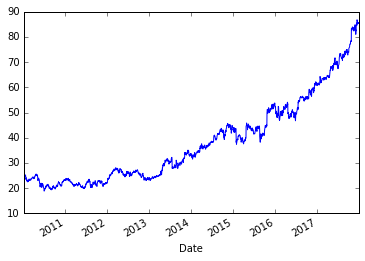

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

df['Close'].plot()

In [3]:
import backtrader as bt
from datetime import datetime


import backtrader as bt

from btbot.constants import SELL, BUY, HOLD


class CrossOverSider(bt.Indicator):
    """Cross over to determine the side for metalabeling"""
    lines = ('side',)
    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 50),
        # moving average to use
        ('_movav', bt.indicators.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast, plot=False, subplot=False)
        sma_slow = self.p._movav(period=self.p.slow, plot=False, subplot=False)

        self.crossover = bt.indicators.CrossOver(sma_fast, sma_slow, plot=False, subplot=False)

    def next(self):
        if self.crossover[0] < 0:
            self.lines.side[0] = SELL
        elif self.crossover[0] > 0:
            self.lines.side[0] = BUY
        else:
            self.lines.side[0] = HOLD

In [5]:
from btbot.utils import print_trade_analysis
from btbot.strategies.constants import SELL, BUY, HOLD
from btbot.labelers import BarrierLabeler
from btbot.samplers import CUSUMFilter, BasicSampler
from btbot.indicators import EMAVolatility
from btbot.siders import CrossOverSider
from btbot.features import PriceVolumeFeature
from collections import deque
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import numpy as np
from abc import abstractmethod

from backtrader.analyzers import SharpeRatio_A, DrawDown, TradeAnalyzer, TimeFrame, Returns


model_params = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'multi:softmax', 'num_class': 3, 
         'sample_type': 'uniform',
         'rate_drop': 0.1,
         'skip_drop': 0.5,
         'silent': True}

SELL_TYPE = 'SELL'
BUY_TYPE = 'BUY'


class BaseStrategy(bt.Strategy):
    def __init__(self):
        self.count = 0 
        self.train_count = 0
        self.model = None
        
    @abstractmethod
    def observe(self):
        """Store data"""
        raise NotImplementedError()
        
    @abstractmethod
    def process(self):
        raise NotImplementedError()
        
    @abstractmethod
    def fit(self):
        raise NotImplementedError()
        
    @abstractmethod
    def predict(self, model):
        raise NotImplementedError()
        
    def execute(self, orders):
        print('orders', orders)
        for order in orders:
            pos = self.getpositionbyname('stock').size
            print('pos', pos)
            if order['type'] == SELL_TYPE:
                if pos >= 0:
                    size = order['size'] + abs(pos)
                    self.sell(data=self.stock, size=size)
            elif order['type'] == BUY_TYPE:
                if pos <= 0:
                    size = order['size'] + abs(pos)
                    self.buy(data=self.stock, size=size)
        
    @property
    def warmup(self):
        if self.count < self.p.warmup:
            return True
        else:
            return False
    
    @property
    def is_metalabeling(self):
        if self.sider is None:
            return False
        else:
            return True

In [6]:
SELL = -1
HOLD = 0
BUY = 1


class PTLSStrategy(bt.Strategy):
    params = (
        ('warmup', 200),
        ('train_freq', 1),
        ('size', 50),
        ('debug', False),
        ('min_data', 5),
        ('max_data', 100000),
        ('timelag', 10),
        ('num_round', 50),
        ('sider', None),
        ('sider_params', dict()),
        ('sampler', BasicSampler),
        ('sampler_params', dict()),
        ('labeler', BarrierLabeler),
        ('labeler_params', dict(period=20, devfactor=1, forward=5)))

    def __init__(self):
        super(MLStrategy, self).__init__()
        self.stock = self.getdatabyname('stock')
        self.sampler = self.p.sampler(**self.p.sampler_params)
        if self.p.sider:
            self.p.labeler_params['sider'] = self.p.sider
            self.p.labeler_params['sider_params'] = self.p.sider_params
            sider = self.p.sider(**self.p.sider_params)
        else:
            self.p.labeler_params['sider'] = None
        self.labeler = self.p.labeler(**self.p.labeler_params)
        # Sider
        if self.p.sider is None:
            self.sider = None
        else:
            self.sider = self.p.sider(**self.p.sider_params)
        self.feature = PriceVolumeFeature(self.stock)
        
    def next(self):
        pass
    

In [7]:
from btbot.cerebro import Cerebro


def get_cerebro(startcash=10000):
    cerebro = Cerebro()
    cerebro.broker.setcash(startcash)
    # cerebro.addanalyzer(TradeAnalyzer, _name='trade')
    # cerebro.addanalyzer(DrawDown, _name='drawdown')
    # cerebro.addanalyzer(SharpeRatio_A, _name='sharpe', timeframe=TimeFrame.Days)
    # cerebro.addanalyzer(Returns, _name='returns', timeframe=TimeFrame.Days)
    # cerebro.addobserver(bt.observers.DrawDown)
    return cerebro

In [10]:
%%time

cerebro = get_cerebro()

stock = bt.feeds.PandasData(dataname=df, close=0, volume=1)
cerebro.adddata(stock, name='stock')
#  cerebro.adddata(macro, name='macro')
# sampler = CUSUMFilter
# sampler_params = dict(period=20, devfactor=1)
# sider = CrossOverSider
sider = None
sider_params = dict(slow=30, fast=10)
labeler = BarrierLabeler
labeler_params = dict(period=20, devfactor=1.0, horizon=5)
cerebro.addstrategy(PTLSStrategy, sider=sider, sider_params=sider_params, size=100,
                    labeler=labeler, labeler_params=labeler_params)
strategy = cerebro.run()[0]

NameError: name 'MLStrategy' is not defined

In [147]:
cerebro.plot()

UnboundLocalError: local variable 'fig' referenced before assignment

In [15]:
close = df['Close']

In [76]:
max([close.index[-5], close.index[-12], close.index[-2]])

Timestamp('2017-12-28 00:00:00')

In [16]:
# close = pd.Series(close.values)
vol = get_daily_vol(close)

In [17]:
vol.shape

(1590,)

In [18]:

close.shape

(2012,)

In [19]:
vol

Date
2010-01-05         NaN
2010-01-06    0.004568
2010-01-07    0.005361
2010-01-11    0.005695
2010-01-12    0.004918
2010-01-13    0.008141
2010-01-14    0.011997
2010-01-19    0.011463
2010-01-20    0.012188
2010-01-21    0.012766
2010-01-25    0.013042
2010-01-26    0.012604
2010-01-27    0.012171
2010-01-28    0.012558
2010-02-01    0.012349
2010-02-02    0.011892
2010-02-03    0.011593
2010-02-04    0.013156
2010-02-08    0.012894
2010-02-09    0.012891
2010-02-10    0.012501
2010-02-11    0.012230
2010-02-16    0.012850
2010-02-17    0.012660
2010-02-18    0.012672
2010-02-22    0.012358
2010-02-23    0.012460
2010-02-24    0.012371
2010-02-25    0.012086
2010-03-01    0.012065
                ...   
2017-11-01    0.007681
2017-11-02    0.007726
2017-11-06    0.007661
2017-11-09    0.007597
2017-11-13    0.007522
2017-11-14    0.007447
2017-11-15    0.007472
2017-11-16    0.007402
2017-11-20    0.007330
2017-11-21    0.007504
2017-11-24    0.007430
2017-11-27    0.007408
2017-1

In [20]:
close

Date
2010-01-04    25.153472
2010-01-05    25.161599
2010-01-06    25.007183
2010-01-07    24.748741
2010-01-08    24.917785
2010-01-11    24.600827
2010-01-12    24.438284
2010-01-13    24.665844
2010-01-14    25.161599
2010-01-15    25.080328
2010-01-19    25.275379
2010-01-20    24.856832
2010-01-21    24.389521
2010-01-22    23.536173
2010-01-25    23.828749
2010-01-26    23.975038
2010-01-27    24.113199
2010-01-28    23.698715
2010-01-29    22.902256
2010-02-01    23.089180
2010-02-02    23.129816
2010-02-03    23.267977
2010-02-04    22.625934
2010-02-05    22.772222
2010-02-08    22.528408
2010-02-09    22.764095
2010-02-10    22.747841
2010-02-11    22.853494
2010-02-12    22.699078
2010-02-16    23.146070
                ...    
2017-11-16    83.200000
2017-11-17    82.400000
2017-11-20    82.530000
2017-11-21    83.720000
2017-11-22    83.110000
2017-11-24    83.260000
2017-11-27    83.870000
2017-11-28    84.880000
2017-11-29    83.340000
2017-11-30    84.170000
2017-12-01 